In [1]:
from datasets import load_dataset

ds = load_dataset("uitnlp/vietnamese_students_feedback")
ds = ds.remove_columns(['topic'])
ds

Generating train split:   0%|          | 0/11426 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1583 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3166 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment'],
        num_rows: 3166
    })
})

In [2]:
sentiment_order = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

list(sentiment_order.keys())

[0, 1, 2]

In [3]:
df_train = ds['train'].to_pandas()
df_val = ds['validation'].to_pandas()

df_train

,sentence,sentiment
0,slide giáo trình đầy đủ .,2
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2
2,đi học đầy đủ full điểm chuyên cần .,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2
...,...,...
11421,chỉ vì môn game mà em học hai lần mà không qua...,0
11422,em cảm ơn cô nhiều .,2
11423,giao bài tập quá nhiều .,0
11424,"giáo viên dạy dễ hiểu , nhiệt tình .",2


In [4]:
import re

def clean_text(text):
    CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

    # remove html tag
    text = re.sub(CLEANR, '', text)

    text = text.lower()
    # remove dấu câu
    text = re.sub(r'[^\w\s]', '', text)

    return text

def remove_emojis(text):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

def clean_text_preprocessing(text: str) -> str:
    return clean_text(remove_emojis(text)).strip()

df_train['sentence'] = df_train['sentence'].fillna("")
df_train['sentence'] = df_train['sentence'].apply(lambda t: clean_text_preprocessing(t))

df_val['sentence'] = df_val['sentence'].fillna("")
df_val['sentence'] = df_val['sentence'].apply(lambda t: clean_text_preprocessing(t))

df_val

,sentence,sentiment
0,giáo trình chưa cụ thể,0
1,giảng buồn ngủ,0
2,giáo viên vui tính tận tâm,2
3,giảng viên nên giao bài tập nhiều hơn chia nh...,0
4,giảng viên cần giảng bài chi tiết hơn đi sâu ...,0
...,...,...
1578,hướng dẫn lab mơ hồ,0
1579,thầy cho chúng em những bài tập mang tính thực...,2
1580,thầy không dạy nhiều chủ yếu cho sinh viên tự ...,0
1581,em muốn đổi tên môn học vì tên môn là lập trìn...,0


sentiment
2    5643
0    5325
1     458
Name: count, dtype: int64


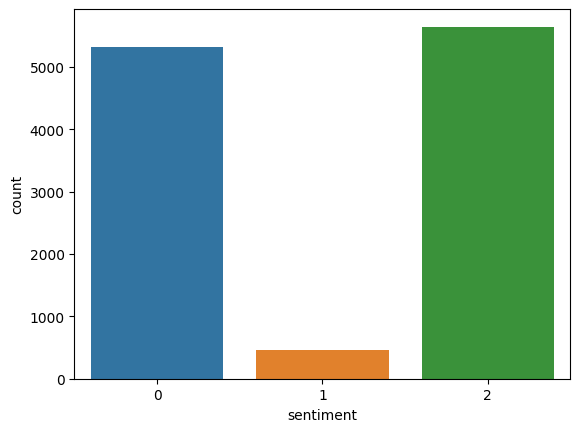

In [5]:
# plot
import matplotlib.pyplot as plt
import seaborn as sns

print(df_train['sentiment'].value_counts())

sns.countplot(data=df_train, x="sentiment", order=list(sentiment_order.keys()))
plt.show()

In [6]:
# remove class neutral
df_train = df_train[df_train['sentiment'] != 1]
df_val = df_val[df_val['sentiment'] != 1]

In [7]:
df_train.loc[df_train['sentiment'] != 0, 'sentiment'] = 1
df_val.loc[df_val['sentiment'] != 0, 'sentiment'] = 1
df_train['sentiment'].value_counts()

sentiment
1    5643
0    5325
Name: count, dtype: int64

sentiment
1    5643
0    5325
Name: count, dtype: int64


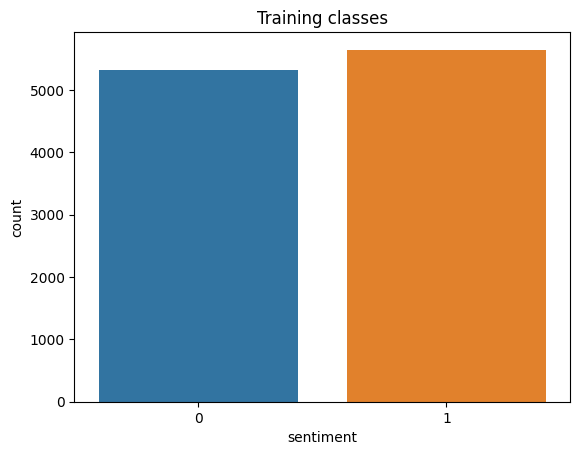

In [8]:
# plot
import matplotlib.pyplot as plt
import seaborn as sns

print(df_train['sentiment'].value_counts())

sns.countplot(data=df_train, x="sentiment", order=sorted(list(df_train['sentiment'].unique())))
plt.title("Training classes")
plt.show()

In [9]:
# Load model directly
from transformers import AutoTokenizer, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
from datasets import Dataset

def preprocessing(data):
    return tokenizer(data['sentence'], truncation=True, padding=True, max_length=128)

train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)

train_dataset = train_dataset.map(preprocessing, batched=True)
val_dataset = val_dataset.map(preprocessing, batched=True)

train_dataset, train_dataset.shape

Map:   0%|          | 0/10968 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

(Dataset({
     features: ['sentence', 'sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 10968
 }),
 (10968, 6))

In [11]:
print(train_dataset[0]['input_ids'])
print(train_dataset[30]['input_ids'])

print(tokenizer.decode(train_dataset[0]['input_ids']))
print(tokenizer.decode(train_dataset[30]['input_ids']))

[0, 48090, 4368, 1893, 545, 312, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2151, 9901, 5415, 940, 204, 53637, 5015, 1427, 16084, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<s> slide giáo trình đầy đủ </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<s> nội dung giảng dạy quá nhàm chán khô khan </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pa

In [12]:
train_dataset = train_dataset.remove_columns(["sentence"])
val_dataset = val_dataset.remove_columns(["sentence"])

train_dataset, val_dataset

(Dataset({
     features: ['sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 10968
 }),
 Dataset({
     features: ['sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 1510
 }))

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=64, collate_fn=data_collator)

train_dataloader, len(train_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x79d554147700>, 172)

### View sample one batch of train_dataloader

In [14]:
for batch in train_dataloader:
    print(batch)
    print(batch.input_ids[22])
    print(tokenizer.decode(batch.input_ids[22]))
    break

{'sentiment': tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0]), '__index_level_0__': tensor([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56,
        57, 58, 59, 60, 61, 62, 63, 64, 65, 66]), 'input_ids': tensor([[    0, 48090,  4368,  ...,     1,     1,     1],
        [    0,  2515,   939,  ...,     1,     1,     1],
        [    0,    57,   222,  ...,     1,     1,     1],
        ...,
        [    0,    77,  3078,  ...,     1,     1,     1],
        [    0,  1249,  1855,  ...,     1,     1,     1],
        [    0,   106,    44,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0,

In [15]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Model init

In [16]:
import torch
from torch import nn

### Add Attention mechanism

In [17]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.Linear(hidden_size, 1, bias=False)


    def forward(self, lstm_out):
        # lstm_output = [batch size, seq_len, hidden_dim]
        attention_scores = self.attn(lstm_out)
        # attention_scores = [batch size, seq_len, 1]
        attention_scores = attention_scores.squeeze(2)
        # attention_scores = [batch size, seq_len]
        return nn.Softmax(dim=1)(attention_scores)

### Build LSTM Model

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, vocal_size, embedding_dim, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.bidirectional = True
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocal_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=self.bidirectional)
        self.attention = Attention(self.hidden_size*2 if self.bidirectional else self.hidden_size)
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(self.hidden_size*2, 64) # hidden_size*2 because of bidirectional = True
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, output_size)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)

        # because shape of embedding out is (batch_size, sequence_len, embedding_dim)
        # then, get batch_size
        batch_size = x.size(0)
        h0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # shape: (batch_size, sequence_len, D*hidden_size)
        # D = 2 if bidirectional = True
        
        attention_weights = self.attention(lstm_out)
        # attention_weights = [batch size, seq_len]
        attention_weights = attention_weights.unsqueeze(2)
        weighted = lstm_out * attention_weights
        # weighted = [batch size, seq_len, hidden_dim]

        weighted_sum = weighted.sum(dim=1)
        # weighted_sum = [batch size, hidden_dim]


#         x = self.dropout(lstm_out[:, -1, :]) # get the last value of each sequence length
        x = self.dropout(weighted_sum) # get the last value of each sequence length
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))

        return x

### Define loss and optimizer

In [19]:
vocal_size = tokenizer.vocab_size
embedding_dim = 128
hidden_size = 64
output_size = 2
num_epochs = 20

model = LSTMModel(vocal_size, embedding_dim, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training

In [20]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [21]:
def train_one_epoch(model, train_dataloader, optimizer, criterion, device):
    train_running_loss = 0.0
    train_correct_item = 0
    total_prediction = 0

    for idx, batch in enumerate(train_dataloader):
        inputs, labels = batch['input_ids'], batch['sentiment']
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        train_running_loss += loss.item()

        _, prediction = torch.max(outputs, 1)
        train_correct_item += (prediction == labels).sum().item()
        total_prediction += labels.size(0)

    train_loss = train_running_loss / len(train_dataloader)
    train_accuracy = train_correct_item / total_prediction

    return train_loss, train_accuracy

In [22]:
def train(model, train_dataloader, val_dataloader, device, num_epochs, criterion, optimizer):
    early_stopping = EarlyStopping(tolerance=5, min_delta=10)

    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []


    for epoch in range(num_epochs):
        model.train(True)

        train_loss, train_accuracy = train_one_epoch(model,
                                                     train_dataloader,
                                                     optimizer,
                                                     criterion,
                                                     device)


        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        ### Evaludate model
        val_loss, val_accuracy = evaluate(model, val_dataloader, criterion, optimizer, device)

        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        # Print epoch statistics
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # early stopping
        early_stopping(train_loss, val_loss)
        if early_stopping.early_stop:
            print("We are at epoch:", epoch + 1)
            break

    print("Training finish")

    train_history = {
        'loss': train_loss_history,
        'accuracy': train_accuracy_history
    }

    val_history = {
        'loss': val_loss_history,
        'accuracy': val_accuracy_history
    }

    return train_history, val_history

#### Evaluate

In [23]:
def evaluate(model, val_dataloader, criterion, optimizer, device):
    model.eval()

    running_loss_eval = 0.0
    val_correct_item = 0
    total_prediction = 0

    with torch.no_grad():
        for idx, batch in enumerate(val_dataloader):
            inputs, labels = batch['input_ids'], batch['sentiment']
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = criterion(outputs, labels)
            running_loss_eval += loss.item()

            _, prediction = torch.max(outputs, 1)
            val_correct_item += (prediction == labels).sum().item()
            total_prediction += labels.size(0)


    val_loss = running_loss_eval / len(val_dataloader)
    val_accuracy = val_correct_item / total_prediction

    return val_loss, val_accuracy


In [24]:
train_history, val_history = train(model,
                                   train_dataloader, val_dataloader,
                                   device,
                                   num_epochs,
                                   criterion,
                                   optimizer)

Epoch [1/20], Train Loss: 0.5621, Val Loss: 0.3968, Train Accuracy: 0.7113, Val Accuracy: 0.9132
Epoch [2/20], Train Loss: 0.3816, Val Loss: 0.3787, Train Accuracy: 0.9297, Val Accuracy: 0.9331
Epoch [3/20], Train Loss: 0.3668, Val Loss: 0.3737, Train Accuracy: 0.9450, Val Accuracy: 0.9377
Epoch [4/20], Train Loss: 0.3570, Val Loss: 0.3713, Train Accuracy: 0.9554, Val Accuracy: 0.9424
Epoch [5/20], Train Loss: 0.3531, Val Loss: 0.3708, Train Accuracy: 0.9600, Val Accuracy: 0.9417
Epoch [6/20], Train Loss: 0.3494, Val Loss: 0.3724, Train Accuracy: 0.9634, Val Accuracy: 0.9391
Epoch [7/20], Train Loss: 0.3460, Val Loss: 0.3729, Train Accuracy: 0.9668, Val Accuracy: 0.9391
Epoch [8/20], Train Loss: 0.3456, Val Loss: 0.3777, Train Accuracy: 0.9673, Val Accuracy: 0.9338
Epoch [9/20], Train Loss: 0.3459, Val Loss: 0.3736, Train Accuracy: 0.9667, Val Accuracy: 0.9377
Epoch [10/20], Train Loss: 0.3416, Val Loss: 0.3723, Train Accuracy: 0.9718, Val Accuracy: 0.9411
Epoch [11/20], Train Loss: 0.

### Plot history

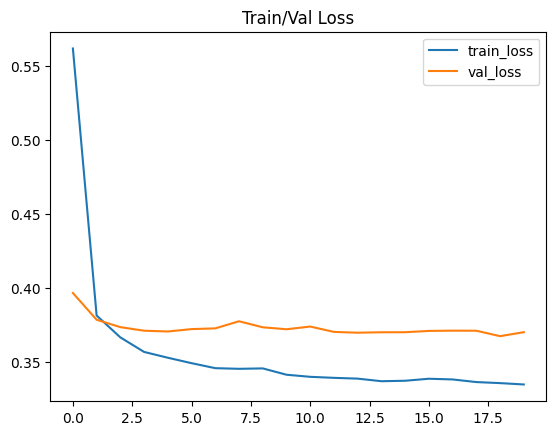

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_history['loss'])
plt.plot(val_history['loss'])

plt.legend(['train_loss', 'val_loss'])
plt.title("Train/Val Loss")

plt.show()

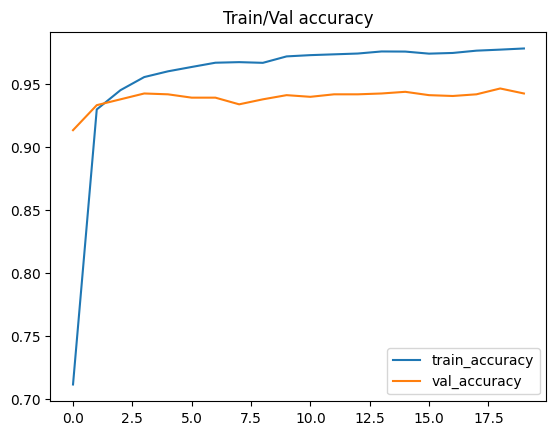

In [26]:
plt.plot(train_history['accuracy'])
plt.plot(val_history['accuracy'])

plt.legend(['train_accuracy', 'val_accuracy'])
plt.title("Train/Val accuracy")

plt.show()

### Test data

In [27]:
df_test = ds['test'].to_pandas()
df_test

,sentence,sentiment
0,nói tiếng anh lưu loát .,2
1,giáo viên rất vui tính .,2
2,cô max có tâm .,2
3,"giảng bài thu hút , dí dỏm .",2
4,"giáo viên không giảng dạy kiến thức , hướng dẫ...",0
...,...,...
3161,"các slide khó hiểu , ngôn ngữ trong slide phức...",0
3162,giáo viên giảng dạy có tâm huyết .,2
3163,chia sẻ cho em nhiều điều hay .,2
3164,em tiếp thu chậm .,0


In [28]:
df_test['sentence'] = df_test['sentence'].fillna("")
df_test['sentence'] = df_test['sentence'].apply(lambda t: clean_text_preprocessing(t))

df_test

,sentence,sentiment
0,nói tiếng anh lưu loát,2
1,giáo viên rất vui tính,2
2,cô max có tâm,2
3,giảng bài thu hút dí dỏm,2
4,giáo viên không giảng dạy kiến thức hướng dẫn...,0
...,...,...
3161,các slide khó hiểu ngôn ngữ trong slide phức ...,0
3162,giáo viên giảng dạy có tâm huyết,2
3163,chia sẻ cho em nhiều điều hay,2
3164,em tiếp thu chậm,0


In [29]:
df_test = df_test[df_test['sentiment'] != 1]
df_test.loc[df_test['sentiment'] != 0, 'sentiment'] = 1
df_test['sentiment'].value_counts()

sentiment
1    1590
0    1409
Name: count, dtype: int64

In [30]:
def process_apply_test(sentence):
    inputs = tokenizer(
        sentence,
        padding='max_length',  # Padding to max length
        truncation=True,
        max_length=128,        # Ensure max length matches the model requirements
        return_tensors='pt'    # Return PyTorch tensors)
    )

    # Move input tensors to device
    input_ids = inputs['input_ids'].to(device)

#     print(input_ids.dim(), input_ids.shape, input_ids)

    model.eval()

    with torch.no_grad():
        outputs = model(input_ids)

    _, predicted_class = torch.max(outputs, 1)
#     print("Predicted class:", sentiment_order[predicted_class.item()])

    return predicted_class.item()


df_test['predicted'] = df_test['sentence'].apply(lambda sentence: process_apply_test(sentence))
df_test

/tmp/ipykernel_23/825882339.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted'] = df_test['sentence'].apply(lambda sentence: process_apply_test(sentence))


,sentence,sentiment,predicted
0,nói tiếng anh lưu loát,1,1
1,giáo viên rất vui tính,1,1
2,cô max có tâm,1,1
3,giảng bài thu hút dí dỏm,1,1
4,giáo viên không giảng dạy kiến thức hướng dẫn...,0,0
...,...,...,...
3160,giảng viên rất nhiệt tình công bằng trong việ...,1,1
3161,các slide khó hiểu ngôn ngữ trong slide phức ...,0,0
3162,giáo viên giảng dạy có tâm huyết,1,1
3163,chia sẻ cho em nhiều điều hay,1,1


In [31]:
df_test['sentiment'].value_counts(), df_test['predicted'].value_counts()

(sentiment
 1    1590
 0    1409
 Name: count, dtype: int64,
 predicted
 1    1543
 0    1456
 Name: count, dtype: int64)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_true=df_test['sentiment'], y_pred=df_test['predicted']))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1409
           1       0.96      0.93      0.94      1590

    accuracy                           0.94      2999
   macro avg       0.94      0.94      0.94      2999
weighted avg       0.94      0.94      0.94      2999



In [33]:
sentence = "cô khó tính quá"
sentence = clean_text_preprocessing(sentence)
print(sentence)

cô khó tính quá


In [34]:
inputs = tokenizer(
    sentence,
    padding='max_length',  # Padding to max length
    truncation=True,
    max_length=128,        # Ensure max length matches the model requirements
    return_tensors='pt'    # Return PyTorch tensors)
)

input_ids = inputs['input_ids'].to(device)

In [35]:
model.eval()

with torch.no_grad():
    outputs = model(input_ids)

    print(outputs)

_, predicted_class = torch.max(outputs, dim=1)

predicted_class.item()

tensor([[1.0000e+00, 1.9680e-11]], device='cuda:0')


0

### Using Softmax function

In [36]:
import torch
softmax = torch.nn.Softmax()
softmax_tensor = softmax(outputs)

softmax_tensor, softmax_tensor.shape

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


(tensor([[0.7311, 0.2689]], device='cuda:0'), torch.Size([1, 2]))

In [37]:
_, pred = torch.max(softmax_tensor, 1)
pred, pred.item()

(tensor([0], device='cuda:0'), 0)

In [38]:
value, predicted_class_2 = torch.max(softmax_tensor, dim=1)
value, predicted_class_2

(tensor([0.7311], device='cuda:0'), tensor([0], device='cuda:0'))